## Sandbox for experiments and tests

## networkX

In [18]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [106]:
raw_data = pd.read_csv("data/t1.csv", delimiter=";").fillna(0.0)
raw_data.head(5)

,ID,Name,Journal,Date,Debit,Credit
0,1,Trade Receivables,Sales ledger,01/01/2017,121.0,0.0
1,1,Revenue,Sales ledger,01/01/2017,0.0,100.0
2,1,Tax,Sales ledger,01/01/2017,0.0,21.0
3,2,Cost of Sales,Journal ledger,01/01/2017,80.0,0.0
4,2,Inventories,Journal ledger,01/01/2017,0.0,80.0


In [107]:
# TODO try another kind of normalization, unit-normal etc.
def normalize(df, by="ID"):
    dfN = df.copy()
    titles = ["Debit", "Credit"]
    groups = dfN.groupby(by)
    sums = groups[titles].transform(np.sum)
    for column in titles:
        dfN[column] = dfN[column]/sums[column]
    dfN["from"] = dfN["Credit"] > 0.0
    return dfN

data = normalize(raw_data)
data.head(5)

,ID,Name,Journal,Date,Debit,Credit,from
0,1,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False
1,1,Revenue,Sales ledger,01/01/2017,0.0,0.826446,True
2,1,Tax,Sales ledger,01/01/2017,0.0,0.173554,True
3,2,Cost of Sales,Journal ledger,01/01/2017,1.0,0.000000,False
4,2,Inventories,Journal ledger,01/01/2017,0.0,1.000000,True


In [108]:
raw_data

,ID,Name,Journal,Date,Debit,Credit
0,1,Trade Receivables,Sales ledger,01/01/2017,121.0,0.0
1,1,Revenue,Sales ledger,01/01/2017,0.0,100.0
2,1,Tax,Sales ledger,01/01/2017,0.0,21.0
3,2,Cost of Sales,Journal ledger,01/01/2017,80.0,0.0
4,2,Inventories,Journal ledger,01/01/2017,0.0,80.0


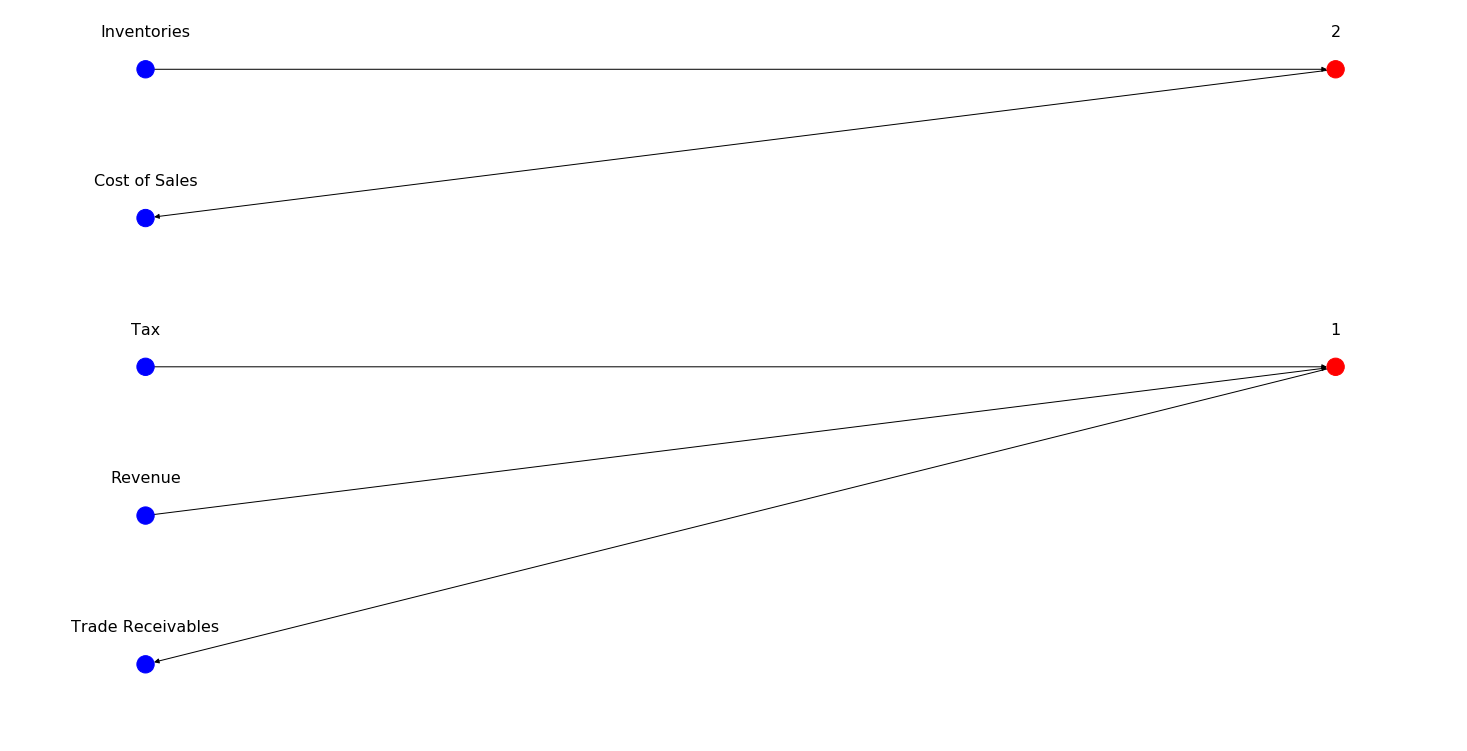

In [88]:
colors = {0: "Blue", 1: "Red"}
B = nx.DiGraph()
B.add_nodes_from(data['ID'], bipartite=0)
B.add_nodes_from(data['Name'], bipartite=1)
B.add_weighted_edges_from(
    [(row['Name'], row['ID'], row["Credit"]) if row["from"]==True 
     else (row['ID'], row['Name'], row["Debit"]) 
     for idx, row in data.iterrows()], 
    weight='weight')

# print(B.edges(data=True))

pos = {node:[0, i] for i,node in enumerate(data['Name'])}
pos.update({node:[1, i] for i,node in enumerate(data['ID'])})
node_col = ["Red" if d['bipartite']==0 else "Blue" for n, d in B.nodes(data=True)]
nx.draw(B, pos, node_color= node_col, with_labels=False)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
nx.draw_networkx_labels(B, pos, font_size=16)

plt.show()